# HIST OF EXTRACTION OF SYMMETRIES

In [ ]:
from template_csp import managetemp_withdict as mte
import numpy as np  
import json
import matplotlib.pyplot as plt

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,
}

complist = [1,2,3,4]
tempinit = 25
tempend = 25 #compreso
mother_dir = './HvsINIT/'

for comp in complist:
    hyperparameters["comp"] = comp  
    same_struct = {}
    with open(f'./SAME_STRUCT_DICT/same_structuresA{comp}B.json') as f:
        same_struct = json.load(f)

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_tot in range(tempinit, tempend +1):
        average_res = 0
        for id_set in range(20):
            init_set = mte.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_tot}/TemplateSet_{id_set}')
            fin_set = mte.PairSet(template_set=init_set, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=mother_dir+f'{comp}/{temp_tot}/PairSet_{id_set}')
            final_set_idx = fin_set.reduced_set()
            final_set = [f'{init_set.pairs[x][0][0]}{init_set.pairs[x][0][1]}_{init_set.pairs[x][1]}' for x in final_set_idx]
            average_res += len(final_set)/20
            for temp in final_set:
                for group in same_struct.keys():
                    if temp in same_struct[group]['temp']:
                        same_struct[group]['count'] += 1
                        break
        
        x = [f'{idx}/{key.split(',')[0][1:]}' for idx, key in enumerate(same_struct.keys())]
        x = np.array(x)
        y = [same_struct[key]['count'] for key in same_struct.keys()]
        y = np.array(y)

        idx_sort_y = np.argsort(y)
        x = x[idx_sort_y][::-1]
        y = y[idx_sort_y][::-1]
        

        fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))
        fig.suptitle('FINAL SET COUNT', fontsize=22, y=0.93, fontweight='bold')
        ax1.bar(x, y, color = 'crimson', edgecolor = 'black', linewidth = 2, alpha=0.7)
        ax1.vlines(average_res-1, 0, max(y)+5, colors='blue', linestyles='dashed', label='Average size finale set')
        ax1.set_xlabel('SG (same wyck pos)', fontsize=18)
        ax1.set_xticks(x)
        ax1.set_xticklabels([a.split('/')[1] for a in x], rotation=90)
        ax1.set_ylim(0, max(y)+5)
        ax1.set_ylabel('Count', fontsize=18)
        ax1.legend(loc='upper right', fontsize=16)
        plt.show()
        fig.savefig(f'./FIG/HIST_FINAL_A{comp}B.png')



    

# GENERATE NEW DATA FROM TEMPLATE SET

### SIZE FINAL SET

In [ ]:
from template_csp import managetemp_withdict as mte 
import numpy as np
import json
from tqdm import tqdm

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,

    "n_final_templates" : 1
}

data = {}

complist = [1,2,3,4,6]
n_set = 20
temp_list = [[20,30,40,50],[30, 45, 60, 75], [30, 40, 50, 60], [30, 40, 50, 60], [10,20,30,35]]


mother_dir = './'

for comp, temp_steps in tqdm(zip(complist, temp_list)):

    data[comp] = {}

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_init in temp_steps:
        data[comp][temp_init] = {'errors_before': {}, 'errors_after': {}}
        

        errors_before = np.zeros((2, temp_init))
        errors_after = np.zeros((2, temp_init))

        for size_final in range(1, temp_init + 1, 2):
            hyperparameters["n_final_templates"] = size_final

            er_aft = []
            er_bef = []

            for id_set in range(n_set):
                init_set = mte.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_init}/TemplateSet_{id_set}', comp=comp)
                fin_set = mte.PairSet(template_set=init_set, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=mother_dir+f'{comp}/{temp_init}/PairSet_{id_set}', comp=comp)

                er_bef.append(init_set.err_before())
                er_aft.append(fin_set.total_error())
            
            errors_before[0][size_final-1] = np.mean(er_bef)
            errors_before[1][size_final-1] = np.std(er_bef)
            errors_after[0][size_final-1] = np.mean(er_aft)
            errors_after[1][size_final-1] = np.std(er_aft)
        
        data[comp][temp_init]['errors_before']['mean'] = errors_before[0].tolist()
        data[comp][temp_init]['errors_before']['std'] = errors_before[1].tolist()
        data[comp][temp_init]['errors_after']['mean'] = errors_after[0].tolist()
        data[comp][temp_init]['errors_after']['std'] = errors_after[1].tolist()
    
    with open('./Errors1.json', 'w') as f:
        json.dump(data, f, indent=4)
                

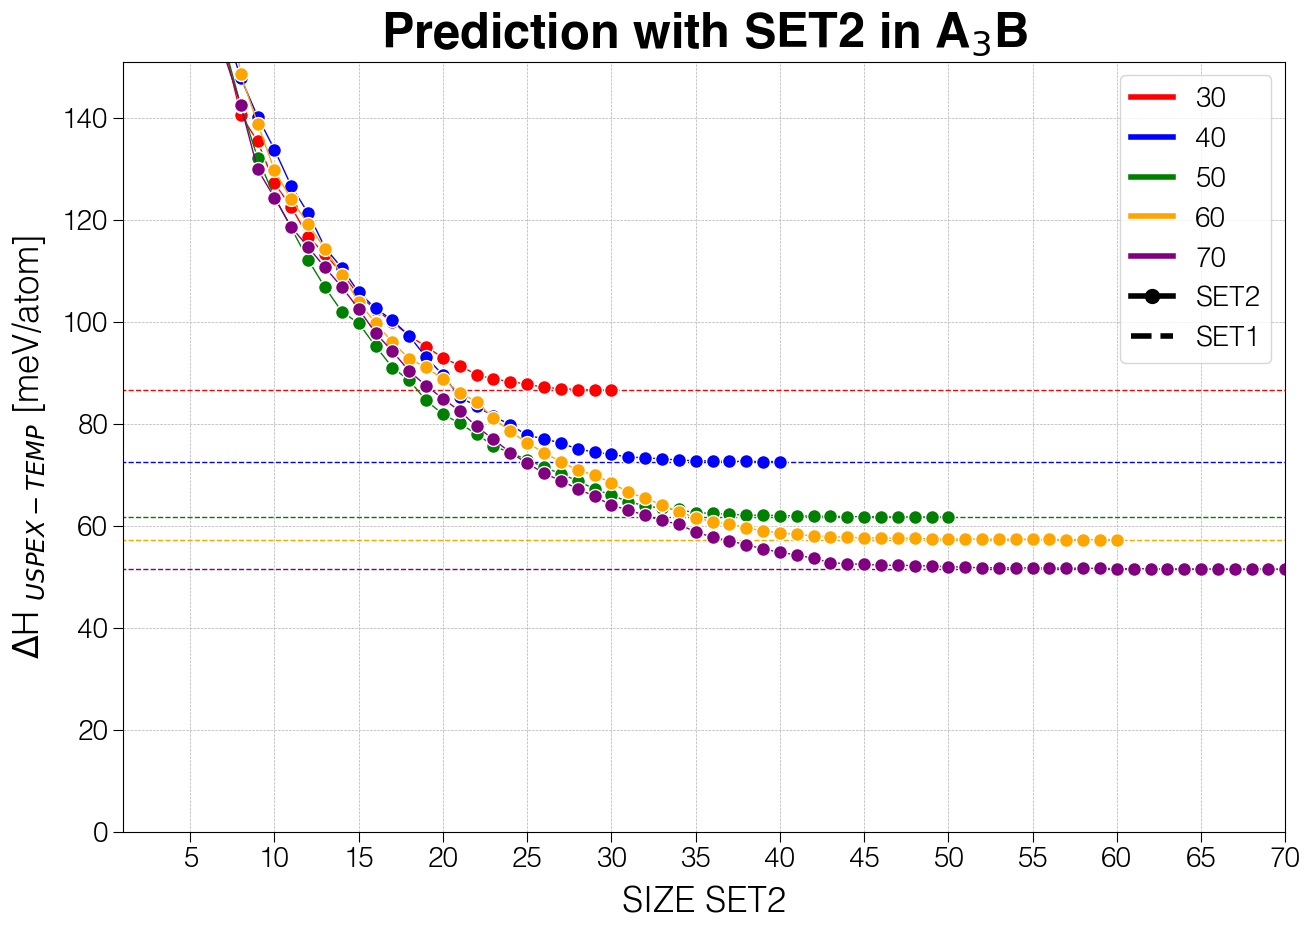

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)


with open('DATA_DICT/Err_vs_SizeFinal.json') as f:
    data = json.load(f)

for comp in data.keys():
    if comp != '3':
        continue
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    title = r'Prediction with SET2 in A$_3$B'
    ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

    colorlist = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

    for idx, temp_init in enumerate(data[comp].keys()):
        x = np.arange(1, int(temp_init)+1)
        y_bef = data[comp][temp_init]['errors_before']['mean'][0]
        y_aft = data[comp][temp_init]['errors_after']['mean']
    
        ax.hlines(y_bef*1000, 0, 70, color=colorlist[idx], lw=1, linestyle='--')
        ax.plot(x, np.array(y_aft)*1000, color=colorlist[idx], lw=1, marker='o', markersize=10, markeredgecolor='white')
        ax.add_artist(plt.Line2D((0, 0), (0, 0), color=colorlist[idx], linestyle='solid', lw=4, label=f'{temp_init}'))
    
    ax.add_artist(plt.Line2D((0, 0), (0, 0),marker='o', markersize=10, color='black', linestyle='solid', lw=4, label='SET2'))
    ax.add_artist(plt.Line2D((0, 0), (0, 0), color='black', linestyle='dashed', lw=4, label='SET1'))

    ax.set_xlabel('SIZE SET2', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.set_xticks(np.arange(0, 101, 5))
    ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, 101, 5)])

    max_y = 151
    min_y = 0

    ax.set_ylabel(r'$\Delta$H $_{USPEX-TEMP}$ [meV/atom]', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.yaxis.set_major_locator(plt.MultipleLocator(20))

    ax.tick_params(size=7, labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(helv_strange_prop)

    ax.legend(loc='upper right', prop=helv_strange_prop, ncol=1, handlelength=1.5)
    ax.set_xlim(1,70)
    ax.set_ylim(min_y,max_y)
    ax.grid(ls = '--', lw = 0.5)
    plt.show()
    fig.savefig(f'./FIG/Articolo/SET2_DH.png')

### VALIDATION PAIRS CONTINUUM

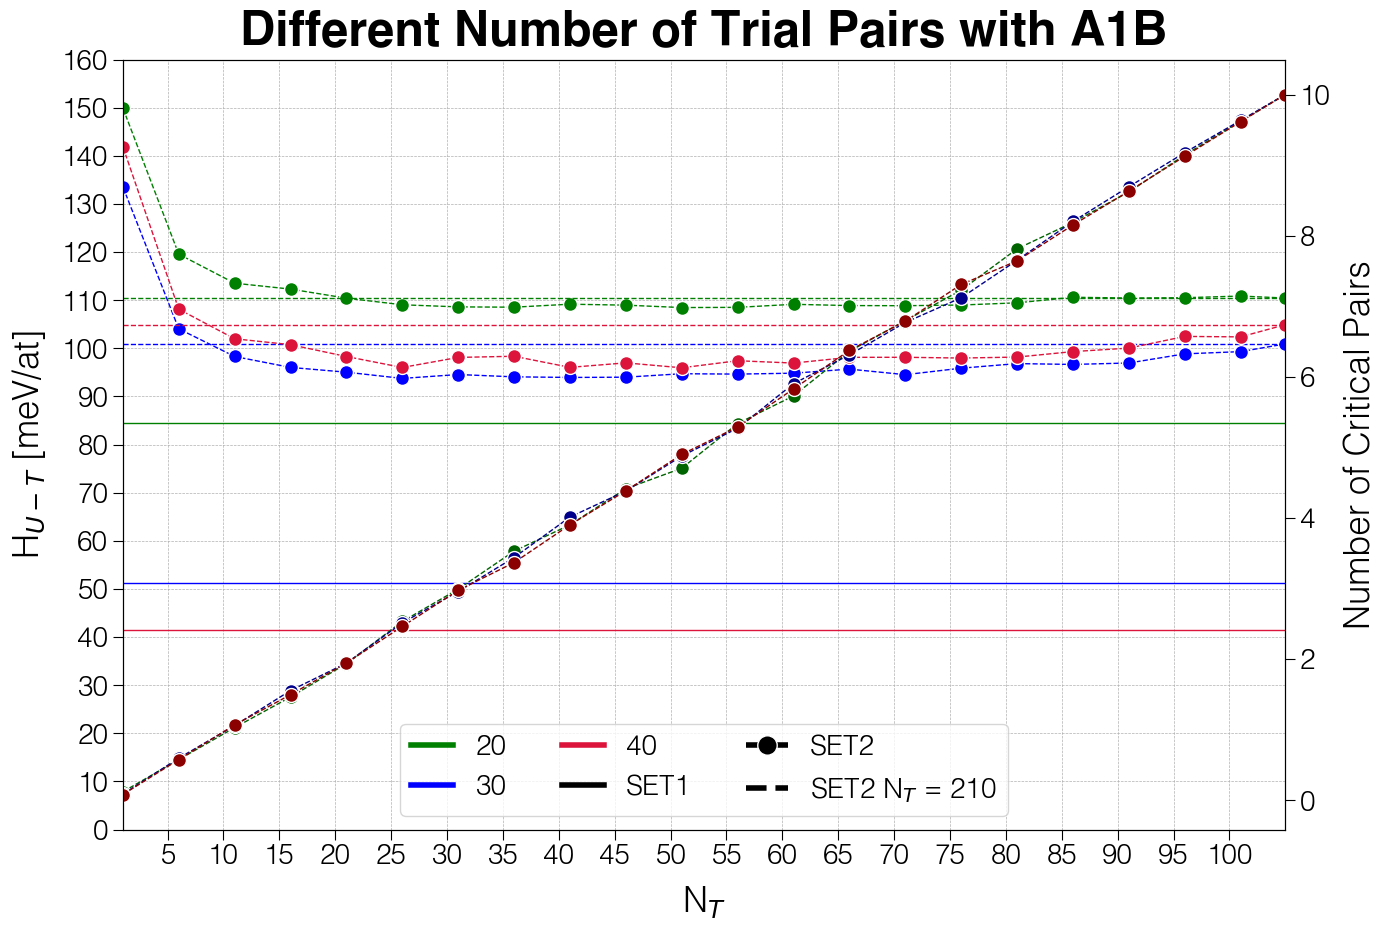

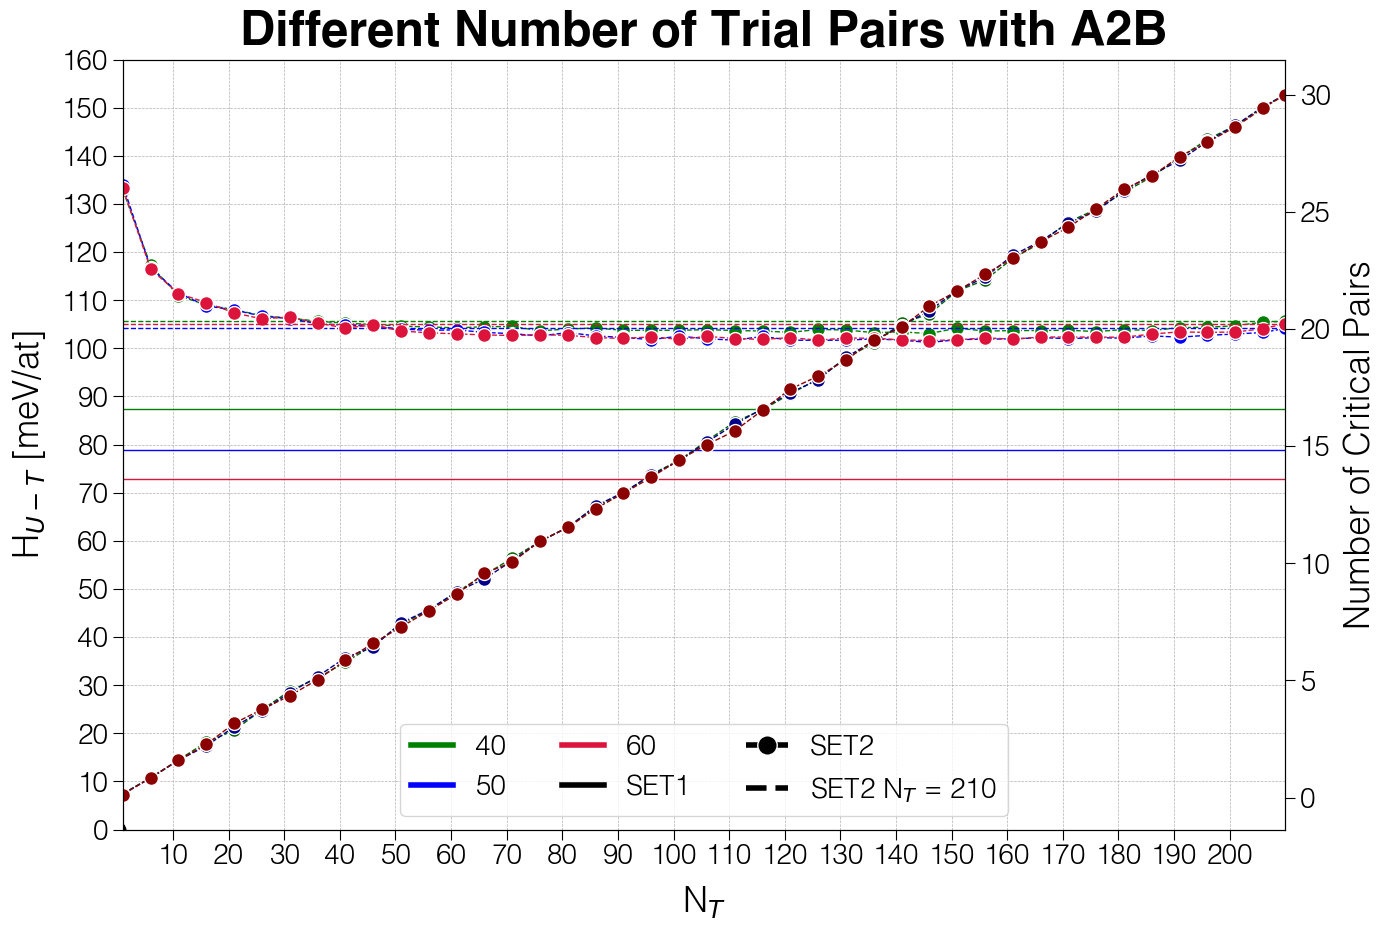

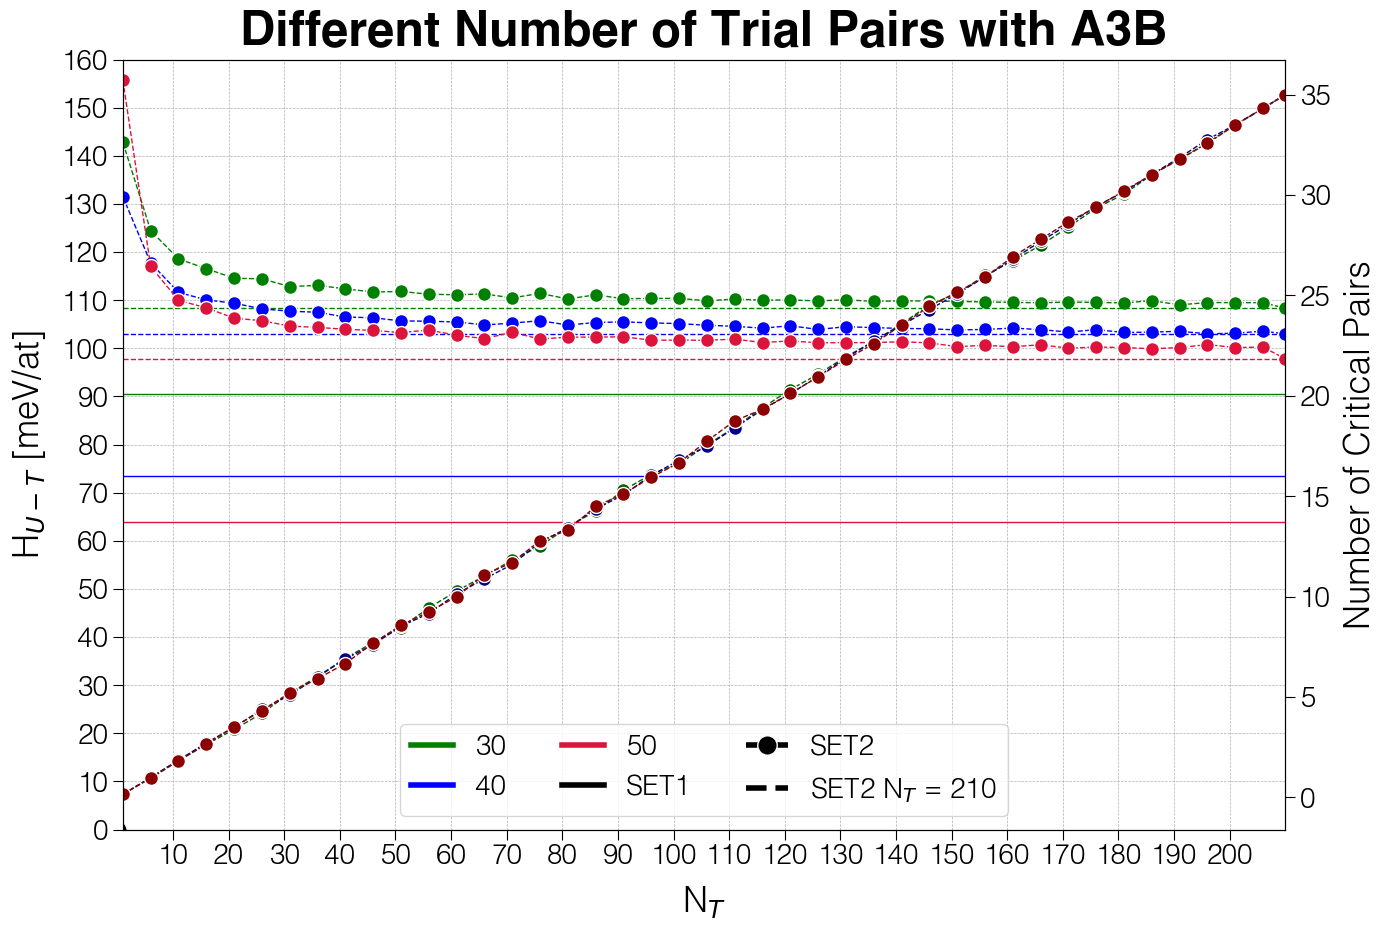

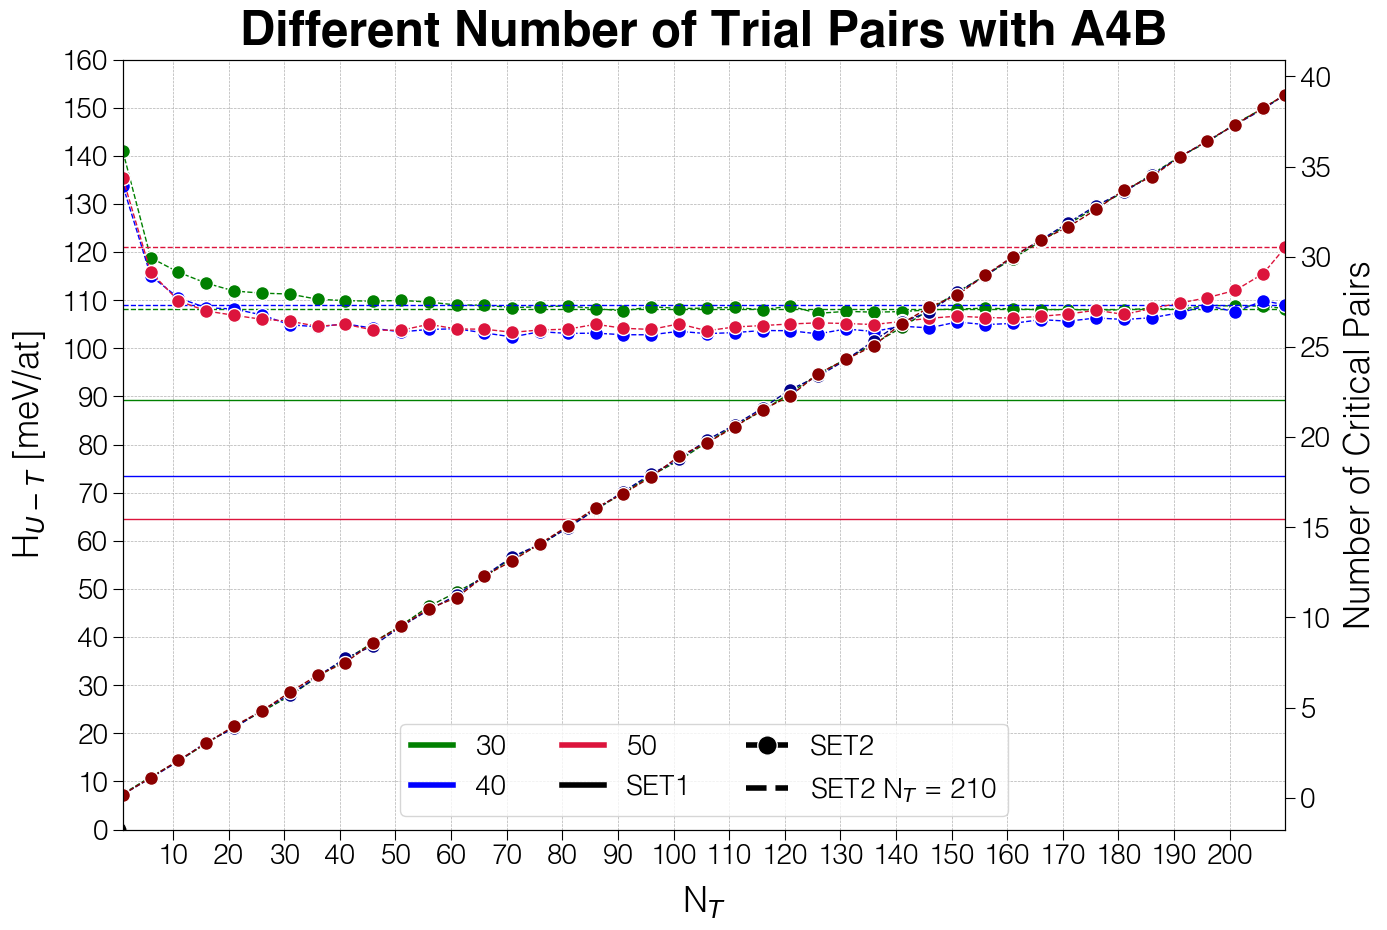

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)

with open('DATA_DICT/NumberOfPairs_Continuum_LinkedtoCrit_AllPerPair.json') as f:
    data = json.load(f)

with open('DATA_DICT/UsedCritPairs.json') as f:
    data_crit = json.load(f)

temp_list = [[20,30,40], [40,50,60], [30,40,50], [30,40,50], [20,30,40]] # template iniziali per ogni comp
temp_final = [10, 20, 15, 15, 10]

for idx_comp, comp in enumerate(data.keys()):

    tot_pairs = 105 if int(comp) == 1 else 210

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    title = f'Different Number of Trial Pairs with A{comp}B'
    ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

    ax2 = ax.twinx()
    


    

    colorlist = ['green', 'blue', 'crimson']
    colorlist2 = ['darkgreen', 'darkblue', 'darkred']

    for idx, temp_init in enumerate(data[comp]['ErrBef'].keys()):

        x = []

        err_bef = data[comp]['ErrBef'][str(temp_init)]
        ax.hlines(err_bef*1000, 1, tot_pairs, colors='black', linestyles='solid',color = colorlist[idx], lw=1)
        y_aft = []

        for npair in data[comp]['ErrAft'][str(temp_init)].keys():
            x.append(int(npair))
            y_aft.append(data[comp]['ErrAft'][str(temp_init)][npair])
        
        ax.plot(x, np.array(y_aft)*1000, color=colorlist[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')

        y_full_pairs = y_aft[-1]
        ax.hlines(y_full_pairs*1000, 1, tot_pairs, color = colorlist[idx], linestyles='dashed', lw=1)
        ax.add_artist(plt.Line2D((0, 0), (0, 0), color=colorlist[idx], linestyle='solid', lw=4, label=str(temp_init)))

        y_crit = []

        for npair in data_crit[comp][str(temp_init)].keys():
            y_crit.append(data_crit[comp][str(temp_init)][npair])
        
        ax2.plot(x, np.array(y_crit), color=colorlist2[idx], lw=1, linestyle='dashed', marker='o', markersize=10, markeredgecolor = 'white')

    

    step_x = 5 if tot_pairs == 105 else 10
    ax.set_xlabel(r'N$_T$', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.set_xticks(np.arange(0, tot_pairs, step_x))
    ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, tot_pairs, step_x)])

    ax2.set_ylabel('Number of Critical Pairs', fontsize=25, font=helvetica_strange, labelpad=10)
    ax2.tick_params(size=7, labelsize=15)
    for label in ax2.get_yticklabels():
        label.set_fontproperties(helv_strange_prop)

    ax.set_ylabel(r'H$_{U-T}$ [meV/at]', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.yaxis.set_major_locator(plt.MultipleLocator(10))
    ax.tick_params(size=7, labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(helv_strange_prop)


    ax.add_artist(plt.Line2D((0, 0), (0, 0), color='black', linestyle='solid', lw=4, label='SET1'))
    ax.add_artist(plt.Line2D((0, 0), (0, 0), color='black', linestyle='dashed', lw=4, label='SET2', marker='o', markersize=14, markeredgecolor = 'white'))
    ax.add_artist(plt.Line2D((0, 0), (0, 0), color='black', linestyle='dashed', lw=4, label=r'SET2 N$_{T}$ = 210'))

    ax.legend(loc='lower center', prop=helv_strange_prop, ncol=3, handlelength=1.5)
    ax.set_xlim(1, x[-1])
    ax.set_ylim(0, 160)
    ax.grid(ls = '--', lw = 0.5)
    plt.show()
    # fig.savefig(f'./FIG/{comp}.png')

# DISTANCES


In [ ]:
from template_csp import managetemp_withdict as mte 
import numpy as np
import json
from tqdm import tqdm
from template_csp.distances import perm_distance

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 
    "comp" : 1,
    "lev_red" : 0.9,
    "n_pairs" : 105,

    "n_final_templates" : 1
}

data = {}

complist = [1,2,3,4]
n_set = 20
# temp_list = [[20, 30, 40, 50, 60], [30, 45, 60, 75, 100], [30, 40, 50, 60, 70], [30, 40, 50, 60, 70]]
temp_list = [[40],[60],[50],[50]]

mother_dir = './HvsINIT/'

for comp, temp_steps in tqdm(zip(complist, temp_list)):

    data[comp] = {'TEMP_INIT' : {'means' : [], 'std': []} , 'TEMP_FINAL': {}}

    if comp == 1:
        hyperparameters["n_pairs"] = 105
    else:
        hyperparameters["n_pairs"] = 210

    for temp_init in temp_steps:
        
        
        errors_after = np.zeros((2, len(range(1, temp_init + 1, 5)), n_set))

        er_bef = []
        for id_set in range(n_set):
            init_set = mte.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=mother_dir+f'{comp}/{temp_init}/TemplateSet_{id_set}', comp=comp)
            er_bef.append(init_set.err_before())

            for idx_size_final, size_final in enumerate(range(1, temp_init + 1, 5)):
                hyperparameters["n_final_templates"] = size_final

                fin_set = mte.PairSet(template_set=init_set, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=mother_dir+f'{comp}/{temp_init}/PairSet_{id_set}', comp=comp, dist_function=perm_distance)
                errors_after[0][idx_size_final][id_set] = fin_set.total_error()
        
        data[comp]['TEMP_INIT']['means'].append(np.mean(er_bef))
        data[comp]['TEMP_INIT']['std'].append(np.std(er_bef))

        for idx_size_final, size_final in enumerate(range(1, temp_init + 1, 5)):
            data[comp]['TEMP_FINAL'][temp_init] = {'means': [], 'std': []}
            data[comp]['TEMP_FINAL'][temp_init]['means'] = np.mean(errors_after[0], axis=1).tolist()
            data[comp]['TEMP_FINAL'][temp_init]['std'] = np.std(errors_after[0], axis=1).tolist()
    
        with open('./Perm_WEIGHTS_Err_vs_SizeFinal.json', 'w') as f:
            json.dump(data, f, indent=4)


                
                

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

with open('Perm_WEIGHTS_Err_vs_SizeFinal.json') as f:
    data = json.load(f)
with open('Err_vs_SizeFinal.json') as f:
    data2 = json.load(f)

for comp in data.keys():
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    fig.suptitle(f'A{comp}B ', fontsize=25, y=0.93, fontweight='bold', family='serif')

    colorlist = ['red', 'blue', 'green', 'orange', 'purple']

    for idx_temp_init, temp_init in enumerate(data[comp]['TEMP_FINAL'].keys()):
        # if idx_temp_init != 3:
        #     continue
        x = range(1, int(temp_init) + 1, 5)
        y_aft = data[comp]['TEMP_FINAL'][temp_init]['means']

        x1 = range(1, int(temp_init) + 1)
        y1_aft = data2[comp][temp_init]['errors_after']['mean']

        # y_aft_std = data[comp]['TEMP_FINAL'][temp_init]['std']
        y_bef = data[comp]['TEMP_INIT']['means'][idx_temp_init]
        ax.hlines(y_bef, 1, int(temp_init), colors='black', linestyles='dashed', label=f'Initial {temp_init}', lw=2)
        ax.plot(x, y_aft, label=f'Final {temp_init} Perm ', color= 'red', lw=2, linestyle='dashed')
        ax.plot(x1, y1_aft, label=f'Final {temp_init} Lev', color= 'blue', lw=2, linestyle='dashed')
        #ax.fill_between(x, y_bef, y_aft, color=colorlist[idx], alpha=0.1)

        ax.set_xlabel('SIZE FINAL SET', fontsize=22, labelpad=10, family='serif')
        ax.set_xticks(np.arange(0, int(temp_init)+1, 5))
        ax.set_xticklabels([f'{x:.0f}' for x in np.arange(0, int(temp_init)+1, 5)], fontsize=18)
        ax.set_xlim(1, int(temp_init))
    
    max_y = 0.101
    min_y = 0.015
    step_y = 0.01


    ax.set_ylabel(r'$\Delta$H w.r.t. USPEX', fontsize=22, labelpad = 10, family='serif')
    ax.set_yticks(np.arange(min_y, max_y, step_y))
    ax.set_yticklabels([f'{x:.2f}' for x in np.arange(min_y, max_y, step_y)], fontsize=18)
    ax.set_ylim(min_y,max_y)


    ax.legend(loc='lower center', fontsize=14, ncol=len(data[comp]['TEMP_FINAL'].keys()))
    
    ax.grid(ls = '--', lw = 0.5)
    plt.show()
    #fig.savefig(f'./FIG/Perm_Err_FinalSize_A{comp}B.png')